## Install statsbombpy library

In [1]:
pip install statsbombpy


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# 1 Creating The Network/Graph

## Import sb from statsbombpy

In [2]:
from statsbombpy import sb

## 1.1 Determine starting conditions
### This notebook is very general in it's format, fill in the following below and every cell will run without any other modifications needed:
Variables to fill out:
1. match_id

In [310]:
# match_id = 18245 was Real-Madrid vs liverpool in the champions league final 2018-05-26
# match_id = 9924 was Real-Madrid vs Barcelona in La Liga 2017/2018 (2018-05-06)
# match_id = 9736 was Real-Madrid vs Barcelona in La Liga 2017/2018 (2017-12-23)
# match_id = 267569 was Real-Madrid vs Barcelona in La Liga 2016/1017 (2017-04-23)
# match_id = 267076 was Real-Madrid vs Barcela in La Liga 2016/2017 (2016-12-03)
match_id = 267076

## 1.2 Select the event
### ie. select all the data from the match with match id = ...

In [311]:
# Select the match
events=sb.events(match_id=match_id)

# Get the team info
teams = events['team'].unique()
team1 = teams[0]
team2 = teams[1]

## 1.3 Create a list for each teams starting XI

In [312]:
# Getting team 1's starting XI
team1_data = events.loc[events['team'] == team1]
team1_starting_xi_data = team1_data.loc[events['type'] == 'Starting XI']

team1_starting_xi = []
for player in team1_starting_xi_data['tactics'][0]['lineup']:
    team1_starting_xi.append(player['player']['name'])
    
    
# Getting team 2's starting XI
team2_data = events.loc[events['team'] == team2]
team2_starting_xi_data = team2_data.loc[events['type'] == 'Starting XI']

team2_starting_xi = []
for player in team2_starting_xi_data['tactics'][1]['lineup']:
    team2_starting_xi.append(player['player']['name'])

## 1.4 Massage the data (Split the data into two dataframes, one for each team, and only keep relevant columns)
### Relevant columns are:
- location (starting location of pass)
- pass_end_location (ending location of pass)
- team
- player
- pass recipient
- timestamp

In [313]:
all_events_df = events[['location', 'pass_end_location', 'team', 'player', 'pass_recipient', 'timestamp']].dropna()

team1_df = all_events_df.loc[all_events_df['team'] == team1].reset_index(drop=True)
team2_df = all_events_df.loc[all_events_df['team'] == team2].reset_index(drop=True)

## Import pandas so we can work with the dataframe

In [314]:
import pandas as pd

## 1.5 Split location and pass_end location columns into 2 columns each
### These columns being:
- Split location into start_x, start_y
- Split pass_end_location into end_x, end_y

In [315]:
# Splitting columns for team 1
team1_pass_start_df = pd.DataFrame(team1_df['location'].to_list(), columns=['start_x', 'start_y']).reset_index(drop=True)
team1_df_final = team1_df.join(team1_pass_start_df)
team1_pass_end_df = pd.DataFrame(team1_df['pass_end_location'].to_list(), columns=['end_x', 'end_y']).reset_index(drop=True)
team1_df_final = team1_df_final.join(team1_pass_end_df)

# Splitting columns for team 2
team2_pass_start_df = pd.DataFrame(team2_df['location'].to_list(), columns=['start_x', 'start_y']).reset_index(drop=True)
team2_df_final = team2_df.join(team2_pass_start_df)
team2_pass_end_df = pd.DataFrame(team2_df['pass_end_location'].to_list(), columns=['end_x', 'end_y']).reset_index(drop=True)
team2_df_final = team2_df_final.join(team2_pass_end_df)

## 1.6 Massage the dataframes more so we are left with these columns:
- player
- pass_recipient
- start_x
- start_y
- end_x
- end_y

In [316]:
# Dropping irrelevant columns for team 1
team1_df_final = team1_df_final.drop(columns=['location', 'pass_end_location', 'timestamp', 'team'])

# Dropping irrelevant columns for team 2
team2_df_final = team2_df_final.drop(columns=['location', 'pass_end_location', 'timestamp', 'team'])

## 1.7 Drop the rows which don't contain players in the starting XI, we are not interested in data about substitutes

In [317]:
# Only keeping rows which contain players in the starting XI
team1_df_final = team1_df_final[team1_df_final['player'].isin(team1_starting_xi)]
team1_df_final = team1_df_final[team1_df_final['pass_recipient'].isin(team1_starting_xi)]
# positions = []
# for player in team1_df_final['player']:
#     for player2 in team1_starting_xi_data['tactics'][0]['lineup']:
#         if (player == player2['player']['name']):
#             positions.append(player2['position'])

# team1_df_final['position'] = positions

# positions = []
# for player in team1_df_final['pass_recipient']:
#     for player2 in team1_starting_xi_data['tactics'][0]['lineup']:
#         if (player == player2['player']['name']):
#             positions.append(player2['position'])

# team1_df_final['pass_recipient_position'] = positions
# print(team1_df_final)

# Only keeping rows which contain players in the starting XI
team2_df_final = team2_df_final[team2_df_final['player'].isin(team2_starting_xi)]
team2_df_final = team2_df_final[team2_df_final['pass_recipient'].isin(team2_starting_xi)]
# print(team2_df_final)

## 1.8 Massage the data even more to have average start_x and start_y columns. This the the position on the field (in our graph), these nodes will be placed

### The final dataframes will have these columns:
- player
- start_x (an average of all this players start_x positions)
- start_y (an average of all this players start_y positions)

In [318]:
# Massage data as described above for team 1
team1_average_df = team1_df_final.groupby('player').agg({'start_x': 'mean', 'start_y': 'mean'}).reset_index()
# positions = []
# for player in team1_average_df['player']:
#     for player2 in team1_starting_xi_data['tactics'][0]['lineup']:
#         if (player == player2['player']['name']):
#             positions.append(player2['position'])

# team1_average_df['position'] = positions
# print(team1_average_df)


# Massage data as described above for team 1
team2_average_df = team2_df_final.groupby('player').agg({'start_x': 'mean', 'start_y': 'mean'}).reset_index()
# positions = []
# for player in team2_average_df['player']:
#     for player2 in team2_starting_xi_data['tactics'][1]['lineup']:
#         if (player == player2['player']['name']):
#             positions.append(player2['position'])

# team2_average_df['position'] = positions
# team2_average_df

## 1.9 Now it's time to make the graphs
### The graph should be created as follows:
- One directed graph for each team
    - Each node represents a player on a team's starting XI
        - Nodes are position according to the players average start_x and start_y position
    - An edge exists between two nodes (players) IF, in the match one played a pass to another
        - Add weights to edges: The weight of an edge is the total number of passes a player played to another throughout the match
        
### THE COMMENTED OUT CODE IS SOMETHING TO TRY: ONLY INCREMENT THE WEIGHT OF AN EDGE FOR EVERY 2 PASSES

In [319]:
import networkx as nx

# Create graph for team 1
G1 = nx.DiGraph()

# Add nodes with player names and their average starting positions
for index, row in team1_average_df.iterrows():
    G1.add_node(row['player'], x=row['start_x'], y=row['start_y'])
#     G1.add_node(row['position']['id'], x=row['start_x'], y=row['start_y'], position=row['position'], name=row['player'])
    
# Creating a map to store the number of passes each player plays to another
team1_player_pass_counts = {}
for player in team1_starting_xi:
    pass_recipients = {}
    for player2 in team1_starting_xi:
        pass_recipients[player2] = 0
    
    team1_player_pass_counts[player] = pass_recipients

# Add edges
for index, row in team1_df_final.iterrows():
    player = row['player']
#     player = row['position']['id']
    pass_recipient = row['pass_recipient']

#     if G1.has_node(player) and G1.has_node(pass_recipient):
#         if G1.has_edge(player, pass_recipient):
#             # Edge already exists, increment the weight
#             G1[player][pass_recipient]['weight'] += 1
#         else:
#             # Edge doesn't exist, create it with weight 1
#             G1.add_edge(player, pass_recipient, weight=1)

    # Increament edge wight/add edge for every 2 passes between players
    team1_player_pass_counts[player][pass_recipient] += 1
    if G1.has_edge(player, pass_recipient):
        # Edge already exists, increment the pass count map and weight if needed
        if (team1_player_pass_counts[player][pass_recipient] % 2 == 0):
            G1[player][pass_recipient]['weight'] += 1
    else:
        # Edge doesn't exist, create it with weight 1
        if (team1_player_pass_counts[player][pass_recipient] % 2 == 0):
            G1.add_edge(player, pass_recipient, weight=1)
            

# Create graph for team 2
G2 = nx.DiGraph()

# Add nodes with player names and their average starting positions
for index, row in team2_average_df.iterrows():
    G2.add_node(row['player'], x=row['start_x'], y=row['start_y'])
    
# Creating a map to store the number of passes each player plays to another
team2_player_pass_counts = {}
for player in team2_starting_xi:
    pass_recipients = {}
    for player2 in team2_starting_xi:
        pass_recipients[player2] = 0
    
    team2_player_pass_counts[player] = pass_recipients
    
# Add edges
for index, row in team2_df_final.iterrows():
    player = row['player']
    pass_recipient = row['pass_recipient']

#     if G2.has_node(player) and G2.has_node(pass_recipient):
#         if G2.has_edge(player, pass_recipient):
#             # Edge already exists, increment the weight
#             G2[player][pass_recipient]['weight'] += 1
#         else:
#             # Edge doesn't exist, create it with weight 1
#             G2.add_edge(player, pass_recipient, weight=1)

    # Increament edge wight/add edge for every 2 passes between players
    team2_player_pass_counts[player][pass_recipient] += 1
    # Increament edge wight/add edge for every 2 passes between players
    if G2.has_edge(player, pass_recipient):
        # Edge already exists, increment the pass count map and weight if needed
        if (team2_player_pass_counts[player][pass_recipient] % 2 == 0):
            G2[player][pass_recipient]['weight'] += 1
    else:
        # Edge doesn't exist, create it with weight 1
        if (team2_player_pass_counts[player][pass_recipient] % 2 == 0):
            G2.add_edge(player, pass_recipient, weight=1)

## Install todofcpy so that we can create a nice visualization

In [320]:
pip install todofcpy


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## 1.10 Time to make the plot. 
### Here is the step by step:
- Create a dictionary with keys for each node (player) and the values being a tuple for their average start_x and average start_y position
- Create a dictionary for the edge labels (weights)
- Create a field from todofcpy.visualization.graph
- Use networkx to draw our graph onto the field

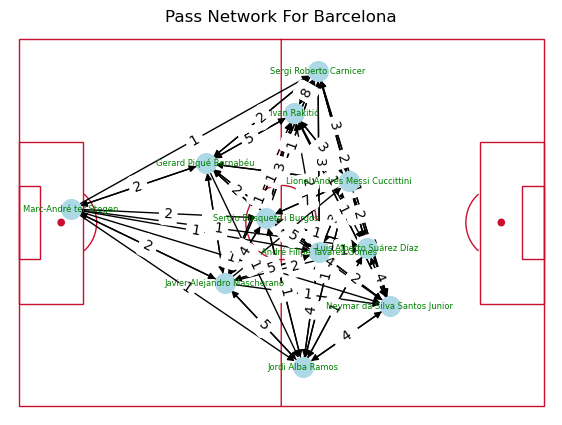

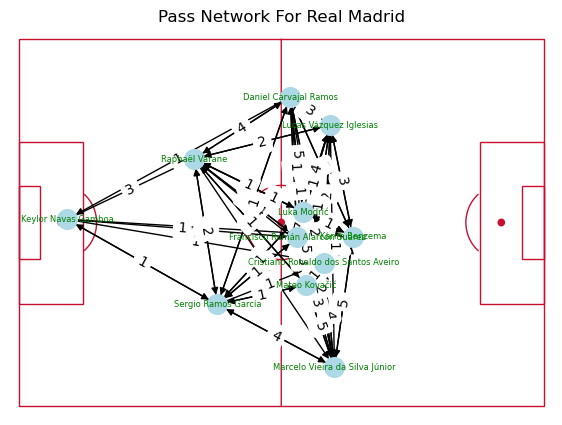

In [321]:
import matplotlib.pyplot as plt
from todofcpy.visualization.graph import Field

# Network visualization for team 1
pos = {player: (team1_average_df.loc[team1_average_df['player'] == player, 'start_x'].values[0], 
                team1_average_df.loc[team1_average_df['player'] == player, 'start_y'].values[0])
                for player in G1.nodes()}
edge_labels = {(u, v): d['weight'] for u, v, d in G1.edges(data=True)}

field = Field()
plt = field.create_field(grass='#FFFFFF', lines = '#C8102E')

nx.draw(G1, pos, with_labels=True, node_size=200, font_size=6, node_color='lightblue', font_color='green')
nx.draw_networkx_edge_labels(G1, pos, edge_labels=edge_labels)
plt.title("Pass Network For " + team1)
plt.show()

# Network visualization for team 2
pos2 = {player: (team2_average_df.loc[team2_average_df['player'] == player, 'start_x'].values[0], 
                team2_average_df.loc[team2_average_df['player'] == player, 'start_y'].values[0])
                for player in G2.nodes()}
edge_labels2 = {(u, v): d['weight'] for u, v, d in G2.edges(data=True)}


field2 = Field()
plt2 = field2.create_field(grass='#FFFFFF', lines = '#C8102E')

nx.draw(G2, pos2, with_labels=True, node_size=200, font_size=6, node_color='lightblue', font_color='green')
nx.draw_networkx_edge_labels(G2, pos2, edge_labels=edge_labels2)
plt2.title("Pass Network For " + team2)
plt2.show()

# 2 Community Detection

## 2.1 Using the Louvain algorithm, we can find the optimal partition which takes into account edge-weights

In [322]:
import networkx.algorithms.community.louvain as louvain

partition1 = louvain.louvain_communities(G1, weight='weight')
print(partition1)

partition2 = louvain.louvain_communities(G2, weight='weight')
print(partition2)

[{'Sergio Busquets i Burgos', 'Sergi Roberto Carnicer', 'Lionel Andrés Messi Cuccittini', 'Ivan Rakitić'}, {'Javier Alejandro Mascherano', 'Gerard Piqué Bernabéu', 'Marc-André ter Stegen'}, {'Jordi Alba Ramos', 'André Filipe Tavares Gomes', 'Neymar da Silva Santos Junior', 'Luis Alberto Suárez Díaz'}]
[{'Daniel Carvajal Ramos', 'Lucas Vázquez Iglesias'}, {'Sergio Ramos García', 'Raphaël Varane', 'Keylor Navas Gamboa'}, {'Francisco Román Alarcón Suárez', 'Luka Modrić'}, {'Cristiano Ronaldo dos Santos Aveiro', 'Mateo Kovačić', 'Karim Benzema', 'Marcelo Vieira da Silva Júnior'}]


# 3 Motif Detection

## 3.1
1. Download sageMath from https://github.com/3-manifolds/Sage_macOS/releases
2. Run the sage-math application from the applications folder, and open this notebook from within that application
3. Now we are ready, let's count the occurences of all the size 3 motifs in our network (one team's pass map)

In [323]:
import numpy
from sage.graphs.graph import DiGraph

# Edge lists of all possible motifs of size 3
size_3_motifs = [
    [(1, 0), (1, 2)],
    [(1, 0), (2, 1)],
    [(1, 0), (1, 2), (2, 1)],
    [(1, 0), (2, 0)],
    [(1, 0), (1, 2), (2, 1)],
    [(1, 0), (1, 2), (2, 1), (2, 0)],
    [(0, 1), (1, 2), (2, 1)],
    [(0, 1), (1, 0), (1, 2), (2, 1)],
    [(0, 1), (1, 2), (2, 0)],
    [(0, 1), (1, 0), (1, 2), (2, 0)],
    [(0, 1), (1, 0), (2, 1), (2, 0)],
    [(0, 1), (1, 0), (1, 2), (2, 1), (2, 0)],
    [(0, 1), (1, 0), (1, 2), (2, 1), (2, 0), (0, 2)]
]

# Turning the edge lists into directed graphs
M1 = DiGraph(size_3_motifs[0])
M2 = DiGraph(size_3_motifs[1])
M3 = DiGraph(size_3_motifs[2])
M4 = DiGraph(size_3_motifs[3])
M5 = DiGraph(size_3_motifs[4])
M6 = DiGraph(size_3_motifs[5])
M7 = DiGraph(size_3_motifs[6])
M8 = DiGraph(size_3_motifs[7])
M9 = DiGraph(size_3_motifs[8])
M10 = DiGraph(size_3_motifs[9])
M11 = DiGraph(size_3_motifs[10])
M12 = DiGraph(size_3_motifs[11])
M13 = DiGraph(size_3_motifs[12])

# Adding the motif graphs to a map
motif_map = {'M1': M1,
             'M2': M2,
             'M3': M3,
             'M4': M4,
             'M5': M5,
             'M6': M6,
             'M7': M7,
             'M8': M8,
             'M9': M9,
             'M10': M10,
             'M11': M11,
             'M12': M12,
             'M13': M13}

# Getting the edge list of our network and creating a different type of directed graph so we can
# count subgraph occurrences as networkx cannot do that
######################################################################################################
# CHANGE THE BELOW LINE DEPENDING ON WHICH GRAPH CREATED PREVIOUSLY IS REAL-MADRID
G1_edgelist = list(G2.edges)
######################################################################################################
G1_digraph = DiGraph(G1_edgelist)


# Iterating through our network to count the number of occurrences of each motif in our network
for motif, motif_graph in motif_map.items():
    occurrence_list = []
    for subgraph in G1_digraph.subgraph_search_iterator(motif_graph, induced=True):
        occurrence_list.append(subgraph)
        
#     print(len(occurrence_list))

## 3.2 After some magic, ie running the above for all 5 games and storing the results in excel, we can create a DataFrame with the data
### With this DataFrame, we can represent the data in a plot

In [324]:
pip install openpyxl


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


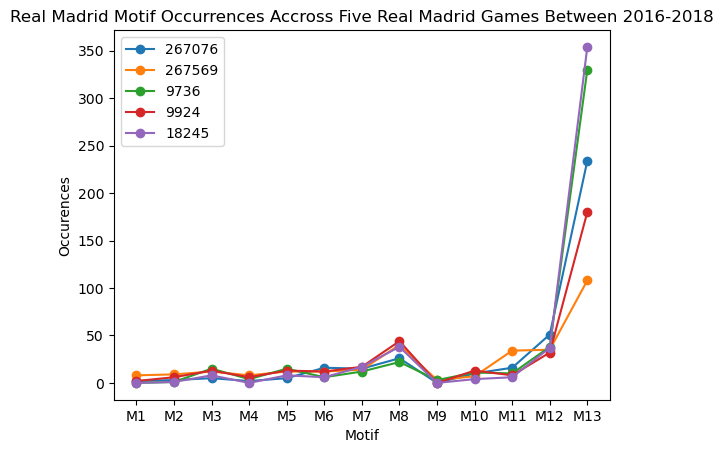

In [325]:
import pandas as pd

# motif_df = pd.read_excel('Motif Occurences.xlsx')

# plt.plot(motif_df['Motif'], motif_df[267076], label='267076', marker='o')
# plt.plot(motif_df['Motif'], motif_df[267569], label='267569', marker='o')
# plt.plot(motif_df['Motif'], motif_df[9736], label='9736', marker='o')
# plt.plot(motif_df['Motif'], motif_df[9924], label='9924', marker='o')
# plt.plot(motif_df['Motif'], motif_df[18245], label='18245', marker='o')

# plt.xlabel('Motif')
# plt.ylabel('Occurences')
# plt.title("Real Madrid Motif Occurrences Accross Five Real Madrid Games Between 2016-2018")
# plt.legend()

# plt.show()

# Same but for when there is an edge every 2 passes
motif_df = pd.read_excel('Motif Occurrences (Edge every 2 passes).xlsx')

plt2.plot(motif_df['Motif'], motif_df[267076], label='267076', marker='o')
plt2.plot(motif_df['Motif'], motif_df[267569], label='267569', marker='o')
plt2.plot(motif_df['Motif'], motif_df[9736], label='9736', marker='o')
plt2.plot(motif_df['Motif'], motif_df[9924], label='9924', marker='o')
plt2.plot(motif_df['Motif'], motif_df[18245], label='18245', marker='o')

plt2.xlabel('Motif')
plt2.ylabel('Occurences')
plt2.title("Real Madrid Motif Occurrences Accross Five Real Madrid Games Between 2016-2018")
plt2.legend()

plt2.show()

## 3.3 Count the motif occurrences in a random model/graph with the same number of nodes and edges as our real-world network

### QUESTION: WHAT RANDOM MODEL SHOULD WE USE?

In [326]:
# n = 11
# ######################################################################################################
# # CHANGE THE BELOW LINE DEPENDING ON WHICH GRAPH CREATED PREVIOUSLY IS REAL-MADRID
# m = len(G2.edges())
# ######################################################################################################

# # Create a random graph with the same number of nodes & edges our real-world network has
# random_graph = nx.gnm_random_graph(n, m, directed=True)

#####################################################################################################
# CHANGE THE BELOW LINE DEPENDING ON WHICH GRAPH CREATED PREVIOUSLY IS REAL-MADRID
G = G2
######################################################################################################

in_degree = dict(G.in_degree())
out_degree = dict(G.out_degree())
in_deg_seq = list(in_degree.values())
out_deg_seq = list(out_degree.values())

random_graph = nx.directed_configuration_model(in_deg_seq, out_deg_seq)
random_graph.remove_edges_from(nx.selfloop_edges(random_graph))

# Turn that random graph into the different type so we can iterate through subgraph occurrences in it
random_graph_edges = list(random_graph.edges)
random_graph2 = DiGraph(random_graph_edges)

total_motif_counts = []   # MOTIF COUNTS FOR RANDOM GRAPH

# Iterating through the random graph to count the number of occurrences of each motif
for motif, motif_graph in motif_map.items():
    occurrence_list = []
    for subgraph in random_graph2.subgraph_search_iterator(motif_graph, induced=True):
        occurrence_list.append(subgraph)
    
    total_motif_counts.append(len(occurrence_list))

## 3.4 Create a network significance profile 
- Create a vector of normalized Z-scores to show us how our data compares to that of a random graph (If a motif is over or under-represented in our real world network compared to a random model)

In [327]:
import numpy as np
import math

# Getting the mean and standard deviation of the number of motif occurrences in our random graph
mean_randomized = np.mean(total_motif_counts)
std_dev_randomized = np.std(total_motif_counts)

# Getting the z-scores of the number of motif occurrences in our real-world network
z_scores = []
for count in motif_df[match_id]: 
    z_scores.append((count - mean_randomized) / std_dev_randomized)

# Normalizing the z-scores
normalized_z_scores = []
denominator = math.sqrt(sum(x**2 for x in z_scores))
for z in z_scores:
    normalized_z_scores.append(z/denominator)
    
for i in normalized_z_scores:
    print(i)

-0.06807445761391177
-0.0635822345226384
-0.05459778834009168
-0.06807445761391177
-0.05459778834009168
-0.005183334336084652
-0.009675557427358017
0.039738896576649016
-0.07705890379645852
-0.032136672883724855
-0.005183334336084652
0.1520444738584832
0.9741212995615092


## 3.5 Like before, I did the above for all 5 games and put the data into excel so it can be imported in. Now, plot the results.

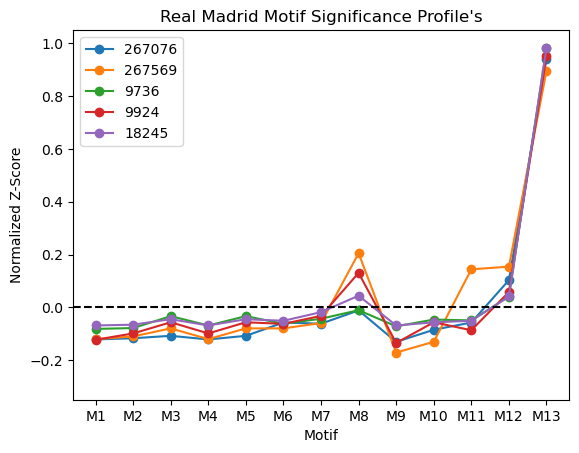

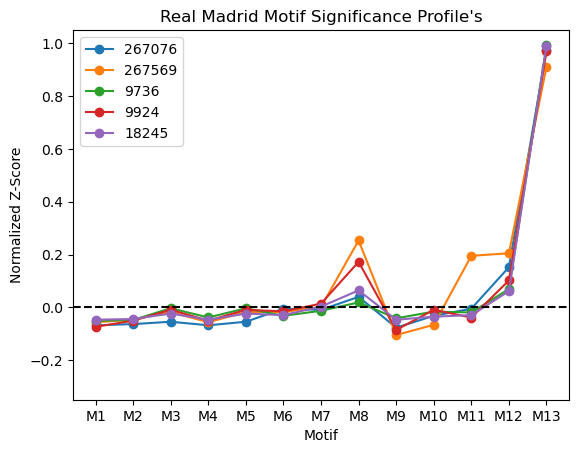

In [329]:
# standardized_motif_z_score_df = pd.read_excel("Motif Standardized Z-Score's.xlsx")

# plt.plot(standardized_motif_z_score_df['Motif'], standardized_motif_z_score_df[267076], label='267076', marker='o')
# plt.plot(standardized_motif_z_score_df['Motif'], standardized_motif_z_score_df[267569], label='267569', marker='o')
# plt.plot(standardized_motif_z_score_df['Motif'], standardized_motif_z_score_df[9736], label='9736', marker='o')
# plt.plot(standardized_motif_z_score_df['Motif'], standardized_motif_z_score_df[9924], label='9924', marker='o')
# plt.plot(standardized_motif_z_score_df['Motif'], standardized_motif_z_score_df[18245], label='18245', marker='o')

# plt.axhline(y=0, color='black', linestyle='--')
# plt.ylim(-0.35, 1.05)


# plt.xlabel('Motif')
# plt.ylabel('Normalized Z-Score')
# plt.title("Real Madrid Motif Significance Profile's")
# plt.legend()

# plt.show()

# Same but for when there is an edge every 2 passes
standardized_motif_z_score_df = pd.read_excel("Motif Standardized Z-Score's (Edge every 2 passes).xlsx")

plt2.plot(standardized_motif_z_score_df['Motif'], standardized_motif_z_score_df[267076], label='267076', marker='o')
plt2.plot(standardized_motif_z_score_df['Motif'], standardized_motif_z_score_df[267569], label='267569', marker='o')
plt2.plot(standardized_motif_z_score_df['Motif'], standardized_motif_z_score_df[9736], label='9736', marker='o')
plt2.plot(standardized_motif_z_score_df['Motif'], standardized_motif_z_score_df[9924], label='9924', marker='o')
plt2.plot(standardized_motif_z_score_df['Motif'], standardized_motif_z_score_df[18245], label='18245', marker='o')

plt2.axhline(y=0, color='black', linestyle='--')
plt2.ylim(-0.35, 1.05)


plt2.xlabel('Motif')
plt2.ylabel('Normalized Z-Score')
plt2.title("Real Madrid Motif Significance Profile's")
plt2.legend()

plt2.show()

# # Same but for Barcelona to see the difference between teams
# standardized_motif_z_score_df = pd.read_excel("Barcelona Motif Standardized Z-Score's (Edge every 2 passes).xlsx")

# plt2.plot(standardized_motif_z_score_df['Motif'], standardized_motif_z_score_df[267076], label='267076', marker='o')
# plt2.plot(standardized_motif_z_score_df['Motif'], standardized_motif_z_score_df[267569], label='267569', marker='o')
# plt2.plot(standardized_motif_z_score_df['Motif'], standardized_motif_z_score_df[9736], label='9736', marker='o')
# plt2.plot(standardized_motif_z_score_df['Motif'], standardized_motif_z_score_df[9924], label='9924', marker='o')

# plt2.axhline(y=0, color='black', linestyle='--')
# plt2.ylim(-0.35, 1.05)


# plt2.xlabel('Motif')
# plt2.ylabel('Normalized Z-Score')
# plt2.title("Barcelona Motif Significance Profile's")
# plt2.legend()

# plt2.show()

# Same but using the configuration model for a random graph
standardized_motif_z_score_df = pd.read_excel("Motif Standardized Z-Score's (Edge every 2 passes, using configuration model).xlsx")

plt2.plot(standardized_motif_z_score_df['Motif'], standardized_motif_z_score_df[267076], label='267076', marker='o')
plt2.plot(standardized_motif_z_score_df['Motif'], standardized_motif_z_score_df[267569], label='267569', marker='o')
plt2.plot(standardized_motif_z_score_df['Motif'], standardized_motif_z_score_df[9736], label='9736', marker='o')
plt2.plot(standardized_motif_z_score_df['Motif'], standardized_motif_z_score_df[9924], label='9924', marker='o')
plt2.plot(standardized_motif_z_score_df['Motif'], standardized_motif_z_score_df[18245], label='18245', marker='o')

plt2.axhline(y=0, color='black', linestyle='--')
plt2.ylim(-0.35, 1.05)


plt2.xlabel('Motif')
plt2.ylabel('Normalized Z-Score')
plt2.title("Real Madrid Motif Significance Profile's")
plt2.legend()

plt2.show()

# 4 RolX

## 4.1
- https://github.com/benedekrozemberczki/RolX
    - From a link in the above GitHub repository: https://github.com/dkaslovsky/GraphRole

In [330]:
pip install graphrole


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [331]:
from graphrole import RecursiveFeatureExtractor, RoleExtractor

######################################################################################################
# CHANGE THE BELOW LINE DEPENDING ON WHICH GRAPH CREATED PREVIOUSLY IS REAL-MADRID
G = G2
positions = pos2
######################################################################################################

feature_extractor = RecursiveFeatureExtractor(G)
features = feature_extractor.extract_features()

print(f'\nFeatures extracted from {feature_extractor.generation_count} recursive generations:')
print(features)


Features extracted from 2 recursive generations:
                                     external_edges(mean)  \
Cristiano Ronaldo dos Santos Aveiro             23.000000   
Daniel Carvajal Ramos                           24.111111   
Francisco Román Alarcón Suárez                  23.000000   
Karim Benzema                                   21.857143   
Keylor Navas Gamboa                             18.800000   
Lucas Vázquez Iglesias                          18.857143   
Luka Modrić                                     19.625000   
Marcelo Vieira da Silva Júnior                  24.250000   
Mateo Kovačić                                   21.285714   
Raphaël Varane                                  23.000000   
Sergio Ramos García                             21.500000   

                                     external_edges(sum)  in_degree(mean)  \
Cristiano Ronaldo dos Santos Aveiro                115.0        19.600000   
Daniel Carvajal Ramos                              217.0       

In [332]:
# assign node roles
role_extractor = RoleExtractor(n_roles=None)
role_extractor.extract_role_factors(features)
node_roles = role_extractor.roles

print('\nNode role assignments:')
print(node_roles)

print('\nNode role membership by percentage:')
print(role_extractor.role_percentage.round(2))


Node role assignments:
{'Cristiano Ronaldo dos Santos Aveiro': 'role_4', 'Daniel Carvajal Ramos': 'role_1', 'Francisco Román Alarcón Suárez': 'role_1', 'Karim Benzema': 'role_4', 'Keylor Navas Gamboa': 'role_6', 'Lucas Vázquez Iglesias': 'role_2', 'Luka Modrić': 'role_5', 'Marcelo Vieira da Silva Júnior': 'role_1', 'Mateo Kovačić': 'role_6', 'Raphaël Varane': 'role_1', 'Sergio Ramos García': 'role_0'}

Node role membership by percentage:
                                     role_0  role_1  role_2  role_3  role_4  \
Cristiano Ronaldo dos Santos Aveiro    0.07    0.01    0.01    0.01    0.41   
Daniel Carvajal Ramos                  0.10    0.39    0.04    0.04    0.01   
Francisco Román Alarcón Suárez         0.04    0.27    0.16    0.16    0.16   
Karim Benzema                          0.12    0.01    0.24    0.24    0.38   
Keylor Navas Gamboa                    0.01    0.01    0.01    0.01    0.16   
Lucas Vázquez Iglesias                 0.12    0.05    0.44    0.01    0.01   
Luka

In [333]:
pip install seaborn


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [334]:
import seaborn as sns

# build color palette for plotting
unique_roles = sorted(set(node_roles.values()))
color_map = sns.color_palette('Paired', n_colors=len(unique_roles))
# map roles to colors
role_colors = {role: color_map[i] for i, role in enumerate(unique_roles)}
# build list of colors for all nodes in G
node_colors = [role_colors[node_roles[node]] for node in G.nodes]

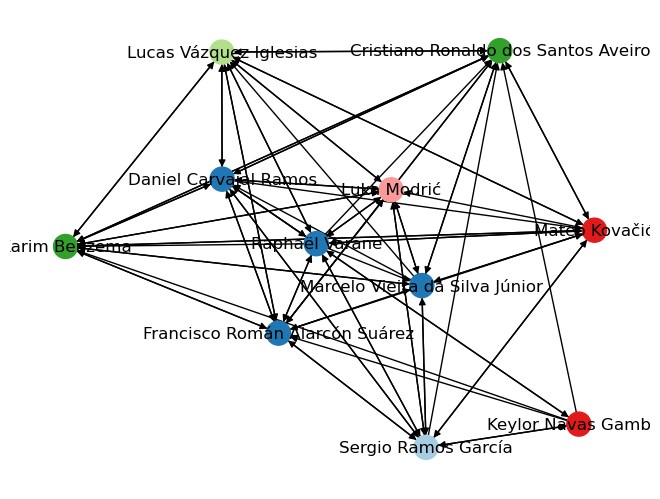

NetworkXError: Node 'Cristiano Ronaldo dos Santos Aveiro' has no position.

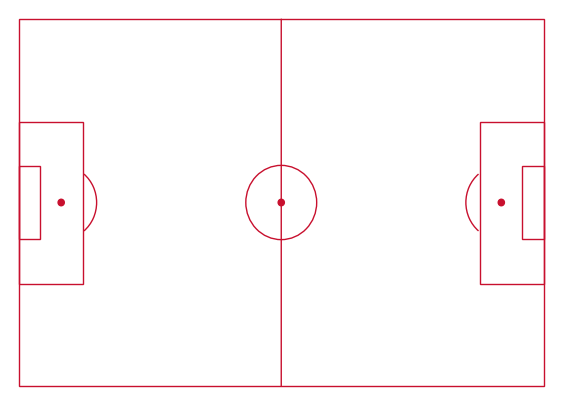

In [335]:
# plot graph
plt.figure()

nx.draw(
    G,
    pos=nx.spring_layout(G, seed=42),
    with_labels=True,
    node_color=node_colors,
)

plt.show()

field2 = Field()
plt2 = field2.create_field(grass='#FFFFFF', lines = '#C8102E')

nx.draw(G, positions, with_labels=True, node_size=200, font_size=6, node_color=node_colors, font_color='green')
nx.draw_networkx_edge_labels(G, positions, edge_labels=edge_labels2)
plt2.title("Pass Network For " + team2)
plt2.show()